In [5]:
import os
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch
from facenet_pytorch import MTCNN
import numpy as np

# Set device (use GPU if available)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Initialize MTCNN
mtcnn = MTCNN(
    image_size=128,     # Output image size
    margin=20,          # Add margin around face
    min_face_size=20,   # Minimum face size to detect
    thresholds=[0.6, 0.7, 0.7],  # MTCNN thresholds
    factor=0.709,       # Scale factor
    post_process=True,  # Normalize image
    device=device
)

# File paths
csv_path = 'balanced_filtered_dataset.csv'
output_dir = 'aligned_faces'

# Source directories
source_dirs = {
    'imdb': 'imdb_crop',
    'wiki': 'wiki_crop'
}

# Create output directory
os.makedirs(output_dir, exist_ok=True)

# Read CSV file
df = pd.read_csv(csv_path)
print(f"Total images in dataset: {len(df)}")

# Create a new dataframe to store successful alignments
aligned_data = []

# Process each image
successful = 0
failed = 0

try:
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing images"):
        rel_path = row['file_path']
        source = row['source']
        source_dir = source_dirs.get(source)
        
        if not source_dir:
            print(f"Unknown source: {source}")
            failed += 1
            continue
        
        # Full path to the image
        img_path = os.path.join(source_dir, rel_path)
        
        # Create a unique filename to avoid path issues
        filename = f"{source}_{rel_path.replace('/', '_')}"
        save_path = os.path.join(output_dir, filename)
        
        try:
            # Open and convert image
            img = Image.open(img_path).convert('RGB')
            
            # Detect face and get aligned face tensor
            face_tensor = mtcnn(img)
            
            if face_tensor is not None:
                # Convert tensor to PIL image and save
                face_pil = Image.fromarray(face_tensor.mul(255).permute(1, 2, 0).byte().numpy())
                face_pil.save(save_path)
                
                # Add to successful alignments
                aligned_data.append({
                    'filename': filename,
                    'age': row['age'],
                    'gender': row['gender'],
                    'age_group': row['age_group'],
                    'source': source
                })
                
                successful += 1
            else:
                print(f"No face detected in {img_path}")
                failed += 1
        
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            failed += 1
    
    # Create and save new CSV with successful alignments
    aligned_df = pd.DataFrame(aligned_data)
    aligned_csv_path = os.path.join(output_dir, 'aligned_dataset.csv')
    aligned_df.to_csv(aligned_csv_path, index=False)
    
    print(f"\nProcessing complete!")
    print(f"Successfully aligned: {successful}")
    print(f"Failed: {failed}")
    print(f"Success rate: {successful/(successful+failed)*100:.2f}%")
    print(f"Aligned dataset saved to: {aligned_csv_path}")

except KeyboardInterrupt:
    print("\nProcessing interrupted by user")
    
    # Save what we've processed so far
    if aligned_data:
        aligned_df = pd.DataFrame(aligned_data)
        aligned_csv_path = os.path.join(output_dir, 'aligned_dataset_partial.csv')
        aligned_df.to_csv(aligned_csv_path, index=False)
        print(f"Partial results saved to: {aligned_csv_path}")

AttributeError: partially initialized module 'torchvision' has no attribute 'extension' (most likely due to a circular import)

In [1]:
import torchvision
print(torchvision.__file__)

c:\Users\athar\anaconda3\Lib\site-packages\torchvision\__init__.py


In [3]:
import os
import pandas as pd
from tqdm import tqdm

# File paths
input_csv_path = 'balanced_filtered_dataset.csv'
output_dir = 'aligned_faces'
output_csv_path = os.path.join(output_dir, 'cleaned_dataset.csv')

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Read the original CSV file
df = pd.read_csv(input_csv_path)
print(f"Original dataset has {len(df)} entries")

# Create a list to store data for successfully processed images
successful_data = []

# Check each image in the directory to see if it exists
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Verifying images"):
    source = row['source']
    rel_path = row['file_path']
    
    # The filename created in the alignment script
    filename = f"{source}_{rel_path.replace('/', '_')}"
    image_path = os.path.join(output_dir, filename)
    
    # If the aligned image exists, add its data to our list
    if os.path.exists(image_path):
        successful_data.append({
            'filename': filename,
            'file_path': row['file_path'],
            'age': row['age'],
            'gender': row['gender'],
            'face_score': row['face_score'],
            'second_face_score': row['second_face_score'],
            'age_group': row['age_group'],
            'source': row['source'],
            'dob': row['dob'],
            'photo_taken': row['photo_taken']
        })

# Create a new DataFrame with only successful entries
cleaned_df = pd.DataFrame(successful_data)

# Save the cleaned CSV
cleaned_df.to_csv(output_csv_path, index=False)

# Print statistics
print(f"\nCleaned dataset has {len(cleaned_df)} entries")
print(f"Success rate: {len(cleaned_df)/len(df)*100:.2f}%")
print(f"CSV saved to: {output_csv_path}")

# Optional: Print age group distribution
if 'age_group' in cleaned_df.columns:
    print("\nAge group distribution in cleaned dataset:")
    print(cleaned_df['age_group'].value_counts().sort_index())

Original dataset has 20746 entries


Verifying images: 100%|██████████| 20746/20746 [00:04<00:00, 4819.04it/s]



Cleaned dataset has 20536 entries
Success rate: 98.99%
CSV saved to: aligned_faces\cleaned_dataset.csv

Age group distribution in cleaned dataset:
age_group
0-10      1976
10-20     2976
20-30     2984
30-40     2970
40-50     1987
50-60     2970
60-70     1973
70-80     1475
80-90      984
90-100     241
Name: count, dtype: int64


In [1]:
import os
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch
import numpy as np
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Set device (use GPU if available)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# First, try to correctly import MTCNN with appropriate error handling
try:
    from facenet_pytorch import MTCNN
    print("Successfully imported facenet_pytorch")
except ImportError as e:
    print(f"Error importing facenet_pytorch: {e}")
    print("Attempting to install facenet_pytorch...")
    os.system("pip install facenet-pytorch")
    from facenet_pytorch import MTCNN

# File paths
csv_path = 'balanced_filtered_dataset.csv'
output_dir = 'aligned_faces'

# Source directories
source_dirs = {
    'imdb': 'imdb_crop',
    'wiki': 'wiki_crop'
}

# Create output directory
os.makedirs(output_dir, exist_ok=True)

# Read CSV file
df = pd.read_csv(csv_path)
print(f"Total images in dataset: {len(df)}")

# Create a new dataframe to store successful alignments
aligned_data = []

# Initialize MTCNN with robust settings
try:
    mtcnn = MTCNN(
        image_size=128,
        margin=20,
        min_face_size=20,
        thresholds=[0.6, 0.7, 0.7],
        factor=0.709,
        keep_all=False,
        device=device
    )
    print("MTCNN initialized successfully")
except Exception as e:
    print(f"Error initializing MTCNN: {e}")
    exit(1)

# Process each image
successful = 0
failed = 0

try:
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing images"):
        if idx % 100 == 0:
            print(f"Processed {idx}/{len(df)} images. Success: {successful}, Failed: {failed}")
        
        rel_path = row['file_path']
        source = row['source']
        source_dir = source_dirs.get(source)
        
        if not source_dir:
            print(f"Unknown source: {source}")
            failed += 1
            continue
        
        # Full path to the image
        img_path = os.path.join(source_dir, rel_path)
        
        # Create a unique filename to avoid path issues
        filename = f"{source}_{rel_path.replace('/', '_')}"
        save_path = os.path.join(output_dir, filename)
        
        try:
            # Check if the file exists
            if not os.path.exists(img_path):
                print(f"File not found: {img_path}")
                failed += 1
                continue
                
            # Open and convert image
            img = Image.open(img_path).convert('RGB')
            
            # Method 1: Use a safer extract approach
            try:
                # Get raw face bounding boxes with confidence
                boxes, probs = mtcnn.detect(img)
                
                # If no faces detected or boxes is None
                if boxes is None or len(boxes) == 0:
                    # Try alternative approach
                    face_img = mtcnn(img, save_path=save_path)
                    if face_img is not None:
                        # Already saved by mtcnn, no need to save again
                        successful += 1
                        
                        # Add to successful alignments
                        aligned_data.append({
                            'filename': filename,
                            'file_path': row['file_path'],
                            'age': row['age'],
                            'gender': row['gender'],
                            'face_score': row['face_score'],
                            'second_face_score': row.get('second_face_score'),
                            'age_group': row['age_group'],
                            'source': source,
                            'dob': row['dob'],
                            'photo_taken': row['photo_taken']
                        })
                    else:
                        print(f"No face detected in {img_path}")
                        failed += 1
                else:
                    # Get highest probability face
                    idx_max = np.argmax(probs)
                    box = boxes[idx_max]
                    
                    # Make sure box is valid
                    if len(box) == 4:
                        # Extract face manually with PIL
                        margin_pixels = 20
                        x1, y1, x2, y2 = [int(val) for val in box]
                        # Add margin
                        x1 = max(0, x1 - margin_pixels)
                        y1 = max(0, y1 - margin_pixels)
                        x2 = min(img.width, x2 + margin_pixels)
                        y2 = min(img.height, y2 + margin_pixels)
                        
                        face_img = img.crop((x1, y1, x2, y2))
                        face_img = face_img.resize((128, 128), Image.BILINEAR)
                        face_img.save(save_path)
                        
                        successful += 1
                        
                        # Add to successful alignments
                        aligned_data.append({
                            'filename': filename,
                            'file_path': row['file_path'],
                            'age': row['age'],
                            'gender': row['gender'],
                            'face_score': row['face_score'],
                            'second_face_score': row.get('second_face_score'),
                            'age_group': row['age_group'],
                            'source': source,
                            'dob': row['dob'],
                            'photo_taken': row['photo_taken']
                        })
                    else:
                        print(f"Invalid bounding box for {img_path}")
                        failed += 1
            except Exception as inner_e:
                print(f"Error in face detection for {img_path}: {inner_e}")
                failed += 1
                
        except Exception as e:
            print(f"Error processing {img_path}: {str(e)}")
            failed += 1
    
    # Create and save new CSV with successful alignments
    if aligned_data:
        aligned_df = pd.DataFrame(aligned_data)
        aligned_csv_path = os.path.join(output_dir, 'aligned_dataset.csv')
        aligned_df.to_csv(aligned_csv_path, index=False)
        
        print(f"\nProcessing complete!")
        print(f"Successfully aligned: {successful}")
        print(f"Failed: {failed}")
        print(f"Success rate: {successful/(successful+failed)*100:.2f}%")
        print(f"Aligned dataset saved to: {aligned_csv_path}")
        
        # Print age group distribution
        if not aligned_df.empty and 'age_group' in aligned_df.columns:
            print("\nAge group distribution in aligned dataset:")
            print(aligned_df['age_group'].value_counts().sort_index())
    else:
        print("No images were successfully processed.")

except KeyboardInterrupt:
    print("\nProcessing interrupted by user")
    
    # Save what we've processed so far
    if aligned_data:
        aligned_df = pd.DataFrame(aligned_data)
        aligned_csv_path = os.path.join(output_dir, 'aligned_dataset_partial.csv')
        aligned_df.to_csv(aligned_csv_path, index=False)
        print(f"Partial results saved to: {aligned_csv_path}")
    else:
        print("No images were successfully processed before interruption.")

Using device: cpu
Successfully imported facenet_pytorch
Total images in dataset: 20746
MTCNN initialized successfully


Processing images:   0%|          | 2/20746 [00:00<21:38, 15.98it/s]

Processed 0/20746 images. Success: 0, Failed: 0


Processing images:   0%|          | 103/20746 [00:04<16:01, 21.47it/s]

Processed 100/20746 images. Success: 100, Failed: 0


Processing images:   1%|          | 203/20746 [00:09<16:57, 20.19it/s]

Processed 200/20746 images. Success: 200, Failed: 0


Processing images:   1%|          | 214/20746 [00:10<19:48, 17.28it/s]

No face detected in imdb_crop\24/nm0266824_rm1239980288_1994-2-23_2001.jpg


Processing images:   1%|▏         | 288/20746 [00:14<20:57, 16.27it/s]

No face detected in imdb_crop\40/nm2978540_rm3065940480_1998-2-11_2008.jpg


Processing images:   1%|▏         | 303/20746 [00:15<16:13, 21.01it/s]

Processed 300/20746 images. Success: 298, Failed: 2


Processing images:   2%|▏         | 403/20746 [00:20<17:06, 19.83it/s]

Processed 400/20746 images. Success: 398, Failed: 2


Processing images:   2%|▏         | 503/20746 [00:24<14:54, 22.63it/s]

Processed 500/20746 images. Success: 498, Failed: 2


Processing images:   3%|▎         | 522/20746 [00:25<15:44, 21.40it/s]

No face detected in imdb_crop\04/nm0000704_rm824544768_1981-1-28_1991.jpg


Processing images:   3%|▎         | 550/20746 [00:26<15:58, 21.06it/s]

No face detected in imdb_crop\01/nm0000301_rm169661952_1982-3-11_1991.jpg


Processing images:   3%|▎         | 603/20746 [00:29<18:24, 18.23it/s]

Processed 600/20746 images. Success: 596, Failed: 4


Processing images:   3%|▎         | 704/20746 [00:34<14:20, 23.28it/s]

Processed 700/20746 images. Success: 696, Failed: 4


Processing images:   4%|▎         | 754/20746 [00:36<14:25, 23.11it/s]

No face detected in imdb_crop\94/nm0001794_rm2352188928_1971-9-9_1982.jpg


Processing images:   4%|▍         | 801/20746 [00:38<15:20, 21.66it/s]

Processed 800/20746 images. Success: 795, Failed: 5


Processing images:   4%|▍         | 903/20746 [00:44<15:31, 21.30it/s]

Processed 900/20746 images. Success: 895, Failed: 5


Processing images:   5%|▍         | 1004/20746 [00:49<13:08, 25.02it/s]

Processed 1000/20746 images. Success: 995, Failed: 5


Processing images:   5%|▌         | 1069/20746 [00:52<17:00, 19.29it/s]

No face detected in imdb_crop\75/nm0001575_rm1077529600_1963-11-5_1973.jpg


Processing images:   5%|▌         | 1102/20746 [00:54<17:00, 19.25it/s]

Processed 1100/20746 images. Success: 1094, Failed: 6


Processing images:   6%|▌         | 1198/20746 [00:59<14:37, 22.27it/s]

No face detected in imdb_crop\22/nm0736622_rm508088576_1982-4-15_1989.jpg
Processed 1200/20746 images. Success: 1193, Failed: 7


Processing images:   6%|▌         | 1226/20746 [01:00<17:16, 18.83it/s]

No face detected in imdb_crop\14/nm0000514_rm8834816_1958-9-25_1964.jpg


Processing images:   6%|▌         | 1294/20746 [01:03<14:59, 21.62it/s]

No face detected in imdb_crop\22/nm0612622_rm951752960_1989-10-25_1995.jpg


Processing images:   6%|▋         | 1303/20746 [01:04<14:50, 21.84it/s]

Processed 1300/20746 images. Success: 1291, Failed: 9


Processing images:   6%|▋         | 1315/20746 [01:04<14:30, 22.33it/s]

No face detected in imdb_crop\81/nm0513281_rm1896978432_1989-1-3_1997.jpg


Processing images:   7%|▋         | 1355/20746 [01:06<12:53, 25.06it/s]

No face detected in imdb_crop\23/nm0046723_rm2067566080_1988-12-5_1994.jpg


Processing images:   7%|▋         | 1361/20746 [01:06<16:13, 19.91it/s]

No face detected in imdb_crop\80/nm0250180_rm3038350848_1980-3-24_1989.jpg


Processing images:   7%|▋         | 1367/20746 [01:06<18:14, 17.71it/s]

No face detected in imdb_crop\46/nm0000346_rm2467859968_1980-8-26_1989.jpg


Processing images:   7%|▋         | 1401/20746 [01:08<15:17, 21.08it/s]

Processed 1400/20746 images. Success: 1387, Failed: 13


Processing images:   7%|▋         | 1459/20746 [01:11<19:03, 16.87it/s]

No face detected in imdb_crop\01/nm0000301_rm85775872_1982-3-11_1991.jpg


Processing images:   7%|▋         | 1494/20746 [01:13<15:34, 20.61it/s]

No face detected in imdb_crop\80/nm0001580_rm3477068800_1986-6-13_1987.jpg


Processing images:   7%|▋         | 1502/20746 [01:13<16:57, 18.92it/s]

Processed 1500/20746 images. Success: 1485, Failed: 15


Processing images:   8%|▊         | 1603/20746 [01:19<16:09, 19.75it/s]

Processed 1600/20746 images. Success: 1585, Failed: 15


Processing images:   8%|▊         | 1656/20746 [01:21<14:28, 21.98it/s]

No face detected in imdb_crop\78/nm0539678_rm1731759616_1984-7-7_1993.jpg


Processing images:   8%|▊         | 1686/20746 [01:23<16:14, 19.55it/s]

No face detected in imdb_crop\25/nm0000825_rm1315163136_1952-10-7_1962.jpg
No face detected in imdb_crop\17/nm0364117_rm218795520_1980-3-2_1989.jpg


Processing images:   8%|▊         | 1701/20746 [01:23<17:19, 18.32it/s]

Processed 1700/20746 images. Success: 1682, Failed: 18
No face detected in imdb_crop\98/nm0933798_rm100710656_1987-7-24_1996.jpg


Processing images:   9%|▊         | 1804/20746 [01:29<15:47, 19.98it/s]

Processed 1800/20746 images. Success: 1781, Failed: 19


Processing images:   9%|▉         | 1825/20746 [01:30<13:39, 23.09it/s]

No face detected in imdb_crop\76/nm2496776_rm3278212608_2001-8-5_2009.jpg


Processing images:   9%|▉         | 1904/20746 [01:33<14:45, 21.28it/s]

Processed 1900/20746 images. Success: 1880, Failed: 20


Processing images:   9%|▉         | 1925/20746 [01:34<15:16, 20.54it/s]

No face detected in imdb_crop\56/nm0005156_rm2856226304_1986-5-19_1994.jpg


Processing images:   9%|▉         | 1934/20746 [01:35<15:47, 19.86it/s]

No face detected in imdb_crop\75/nm0281575_rm2889518592_1984-4-16_1993.jpg


Processing images:  10%|▉         | 1973/20746 [01:36<14:42, 21.26it/s]

No face detected in imdb_crop\82/nm0014582_rm136023552_1990-1-7_2000.jpg


Processing images:  10%|▉         | 2003/20746 [01:38<15:10, 20.60it/s]

No face detected in imdb_crop\81/nm0094581_rm3526987264_1985-8-19_1994.jpg
Processed 2000/20746 images. Success: 1976, Failed: 24


Processing images:  10%|▉         | 2031/20746 [01:39<15:40, 19.90it/s]

No face detected in imdb_crop\77/nm0001377_rm255176960_1951-4-17_1968.jpg


Processing images:  10%|█         | 2084/20746 [01:42<16:25, 18.93it/s]

No face detected in imdb_crop\09/nm0756209_rm1821555200_1967-0-0_1987.jpg


Processing images:  10%|█         | 2103/20746 [01:43<15:21, 20.22it/s]

Processed 2100/20746 images. Success: 2074, Failed: 26


Processing images:  11%|█         | 2198/20746 [01:48<18:51, 16.39it/s]

No face detected in imdb_crop\72/nm0001272_rm3104345600_1971-3-13_1988.jpg


Processing images:  11%|█         | 2203/20746 [01:48<16:35, 18.62it/s]

Processed 2200/20746 images. Success: 2173, Failed: 27


Processing images:  11%|█         | 2302/20746 [01:53<16:20, 18.81it/s]

Processed 2300/20746 images. Success: 2273, Failed: 27


Processing images:  12%|█▏        | 2402/20746 [01:58<14:11, 21.55it/s]

No face detected in imdb_crop\59/nm0334159_rm842123264_1989-9-5_2009.jpg
Processed 2400/20746 images. Success: 2372, Failed: 28


Processing images:  12%|█▏        | 2447/20746 [02:00<13:47, 22.10it/s]

No face detected in imdb_crop\88/nm0000588_rm456494592_1970-11-16_1984.jpg


Processing images:  12%|█▏        | 2502/20746 [02:03<15:37, 19.47it/s]

Processed 2500/20746 images. Success: 2471, Failed: 29


Processing images:  13%|█▎        | 2602/20746 [02:07<15:44, 19.21it/s]

Processed 2600/20746 images. Success: 2571, Failed: 29


Processing images:  13%|█▎        | 2621/20746 [02:08<14:45, 20.47it/s]

No face detected in imdb_crop\77/nm0001377_rm204845312_1951-4-17_1968.jpg
No face detected in imdb_crop\44/nm0005044_rm2851444992_1982-5-11_2002.jpg


Processing images:  13%|█▎        | 2704/20746 [02:13<14:00, 21.46it/s]

Processed 2700/20746 images. Success: 2669, Failed: 31


Processing images:  13%|█▎        | 2777/20746 [02:16<16:01, 18.68it/s]

No face detected in wiki_crop\63/22394963_1948-12-22_1961.jpg


Processing images:  14%|█▎        | 2803/20746 [02:18<15:21, 19.47it/s]

Processed 2800/20746 images. Success: 2768, Failed: 32


Processing images:  14%|█▍        | 2903/20746 [02:22<16:01, 18.57it/s]

Processed 2900/20746 images. Success: 2868, Failed: 32


Processing images:  14%|█▍        | 2947/20746 [02:24<13:23, 22.16it/s]

No face detected in imdb_crop\55/nm6363555_rm2065166592_1996-12-20_2013.jpg


Processing images:  14%|█▍        | 3003/20746 [02:27<14:11, 20.83it/s]

Processed 3000/20746 images. Success: 2967, Failed: 33


Processing images:  15%|█▍        | 3102/20746 [02:31<13:55, 21.12it/s]

Processed 3100/20746 images. Success: 3067, Failed: 33


Processing images:  15%|█▍        | 3108/20746 [02:32<13:47, 21.32it/s]

No face detected in imdb_crop\13/nm0000213_rm3710160384_1971-10-29_1992.jpg


Processing images:  15%|█▌        | 3205/20746 [02:36<11:29, 25.42it/s]

Processed 3200/20746 images. Success: 3166, Failed: 34


Processing images:  16%|█▌        | 3270/20746 [02:39<14:34, 19.97it/s]

No face detected in imdb_crop\83/nm0746583_rm3191115264_1966-11-22_1985.jpg


Processing images:  16%|█▌        | 3304/20746 [02:41<14:13, 20.43it/s]

Processed 3300/20746 images. Success: 3265, Failed: 35


Processing images:  16%|█▋        | 3403/20746 [02:46<13:52, 20.83it/s]

Processed 3400/20746 images. Success: 3365, Failed: 35


Processing images:  17%|█▋        | 3503/20746 [02:51<13:02, 22.05it/s]

Processed 3500/20746 images. Success: 3465, Failed: 35


Processing images:  17%|█▋        | 3602/20746 [02:55<14:30, 19.70it/s]

Processed 3600/20746 images. Success: 3565, Failed: 35


Processing images:  18%|█▊        | 3703/20746 [03:00<12:44, 22.28it/s]

No face detected in imdb_crop\27/nm0001527_rm3944254976_1961-7-18_1981.jpg
Processed 3700/20746 images. Success: 3664, Failed: 36


Processing images:  18%|█▊        | 3706/20746 [03:00<14:26, 19.68it/s]

No face detected in imdb_crop\24/nm0000124_rm1109560832_1970-12-12_1991.jpg


Processing images:  18%|█▊        | 3804/20746 [03:05<13:31, 20.88it/s]

Processed 3800/20746 images. Success: 3763, Failed: 37


Processing images:  19%|█▊        | 3847/20746 [03:07<14:39, 19.20it/s]

No face detected in imdb_crop\06/nm0000106_rm1322031360_1975-2-22_1995.jpg


Processing images:  19%|█▉        | 3903/20746 [03:10<13:31, 20.75it/s]

Processed 3900/20746 images. Success: 3862, Failed: 38


Processing images:  19%|█▉        | 3911/20746 [03:10<15:49, 17.73it/s]

No face detected in imdb_crop\62/nm3141662_rm301121536_1994-3-26_2014.jpg


Processing images:  19%|█▉        | 3949/20746 [03:12<17:22, 16.11it/s]

No face detected in imdb_crop\58/nm0396558_rm1677964032_1989-12-7_2009.jpg


Processing images:  19%|█▉        | 4005/20746 [03:15<12:06, 23.04it/s]

Processed 4000/20746 images. Success: 3960, Failed: 40


Processing images:  20%|█▉        | 4104/20746 [03:20<12:58, 21.39it/s]

Processed 4100/20746 images. Success: 4060, Failed: 40


Processing images:  20%|██        | 4201/20746 [03:24<12:04, 22.85it/s]

Processed 4200/20746 images. Success: 4160, Failed: 40


Processing images:  21%|██        | 4303/20746 [03:29<12:07, 22.61it/s]

Processed 4300/20746 images. Success: 4260, Failed: 40


Processing images:  21%|██        | 4371/20746 [03:32<17:29, 15.60it/s]

No face detected in imdb_crop\60/nm0657760_rm2624166144_1980-9-21_1996.jpg
No face detected in imdb_crop\09/nm0926209_rm3661417472_1958-9-24_1979.jpg


Processing images:  21%|██        | 4403/20746 [03:34<14:06, 19.30it/s]

Processed 4400/20746 images. Success: 4358, Failed: 42


Processing images:  22%|██▏       | 4501/20746 [03:39<12:03, 22.46it/s]

Processed 4500/20746 images. Success: 4458, Failed: 42


Processing images:  22%|██▏       | 4520/20746 [03:40<13:13, 20.45it/s]

No face detected in imdb_crop\77/nm1102577_rm2929902592_1998-4-9_2014.jpg


Processing images:  22%|██▏       | 4602/20746 [03:44<15:36, 17.23it/s]

Processed 4600/20746 images. Success: 4557, Failed: 43


Processing images:  23%|██▎       | 4673/20746 [03:48<16:31, 16.22it/s]

No face detected in imdb_crop\32/nm0114532_rm1999354112_1984-3-0_2000.jpg


Processing images:  23%|██▎       | 4700/20746 [03:49<12:20, 21.67it/s]

No face detected in wiki_crop\74/1090974_1971-03-12_1988.jpg
Processed 4700/20746 images. Success: 4655, Failed: 45


Processing images:  23%|██▎       | 4764/20746 [03:52<11:18, 23.55it/s]

No face detected in imdb_crop\35/nm2633535_rm1763619328_1997-4-1_2011.jpg


Processing images:  23%|██▎       | 4801/20746 [03:54<13:15, 20.06it/s]

Processed 4800/20746 images. Success: 4754, Failed: 46


Processing images:  23%|██▎       | 4857/20746 [03:56<12:49, 20.66it/s]

No face detected in wiki_crop\57/38559257_1952-07-22_1971.jpg


Processing images:  24%|██▎       | 4880/20746 [03:57<09:57, 26.54it/s]

No face detected in imdb_crop\19/nm2765519_rm3173822976_2000-5-30_2011.jpg


Processing images:  24%|██▎       | 4905/20746 [03:59<11:22, 23.21it/s]

Processed 4900/20746 images. Success: 4852, Failed: 48


Processing images:  24%|██▍       | 5002/20746 [04:03<11:25, 22.96it/s]

Processed 5000/20746 images. Success: 4952, Failed: 48


Processing images:  25%|██▍       | 5103/20746 [04:09<14:38, 17.80it/s]

Processed 5100/20746 images. Success: 5052, Failed: 48


Processing images:  25%|██▌       | 5202/20746 [04:14<13:48, 18.77it/s]

Processed 5200/20746 images. Success: 5152, Failed: 48


Processing images:  26%|██▌       | 5304/20746 [04:20<12:54, 19.95it/s]

Processed 5300/20746 images. Success: 5252, Failed: 48


Processing images:  26%|██▌       | 5405/20746 [04:25<11:35, 22.07it/s]

Processed 5400/20746 images. Success: 5352, Failed: 48


Processing images:  26%|██▋       | 5484/20746 [04:29<11:28, 22.15it/s]

No face detected in wiki_crop\95/30122795_1989-04-16_2014.jpg


Processing images:  27%|██▋       | 5502/20746 [04:30<11:24, 22.28it/s]

Processed 5500/20746 images. Success: 5451, Failed: 49


Processing images:  27%|██▋       | 5604/20746 [04:35<12:34, 20.06it/s]

Processed 5600/20746 images. Success: 5551, Failed: 49


Processing images:  27%|██▋       | 5704/20746 [04:40<12:37, 19.86it/s]

Processed 5700/20746 images. Success: 5651, Failed: 49


Processing images:  28%|██▊       | 5802/20746 [04:45<12:01, 20.72it/s]

Processed 5800/20746 images. Success: 5751, Failed: 49


Processing images:  28%|██▊       | 5901/20746 [04:50<12:03, 20.52it/s]

Processed 5900/20746 images. Success: 5851, Failed: 49


Processing images:  28%|██▊       | 5906/20746 [04:51<13:48, 17.91it/s]

No face detected in wiki_crop\12/4505512_1949-05-07_1972.jpg


Processing images:  29%|██▉       | 6002/20746 [04:55<12:55, 19.02it/s]

Processed 6000/20746 images. Success: 5950, Failed: 50


Processing images:  29%|██▉       | 6047/20746 [04:58<12:24, 19.73it/s]

No face detected in imdb_crop\93/nm0555093_rm226466048_1975-2-22_2004.jpg


Processing images:  29%|██▉       | 6104/20746 [05:01<11:12, 21.79it/s]

Processed 6100/20746 images. Success: 6049, Failed: 51


Processing images:  29%|██▉       | 6116/20746 [05:01<11:59, 20.35it/s]

No face detected in imdb_crop\04/nm0654104_rm974559232_1980-9-25_2003.jpg


Processing images:  30%|██▉       | 6202/20746 [05:06<14:06, 17.18it/s]

Processed 6200/20746 images. Success: 6148, Failed: 52


Processing images:  30%|██▉       | 6216/20746 [05:06<14:07, 17.14it/s]

No face detected in wiki_crop\35/46953935_1988-08-17_2014.jpg


Processing images:  30%|███       | 6263/20746 [05:09<11:19, 21.31it/s]

No face detected in imdb_crop\35/nm0001035_rm3638597888_1970-7-31_1997.jpg


Processing images:  30%|███       | 6304/20746 [05:11<12:20, 19.50it/s]

Processed 6300/20746 images. Success: 6246, Failed: 54


Processing images:  31%|███       | 6352/20746 [05:14<16:35, 14.46it/s]

No face detected in imdb_crop\39/nm0666739_rm3598822144_1979-8-27_2008.jpg


Processing images:  31%|███       | 6402/20746 [05:17<16:00, 14.93it/s]

Processed 6400/20746 images. Success: 6345, Failed: 55


Processing images:  31%|███       | 6416/20746 [05:18<14:44, 16.20it/s]

No face detected in imdb_crop\06/nm0000206_rm3743714816_1964-9-2_1992.jpg


Processing images:  31%|███▏      | 6501/20746 [05:22<13:08, 18.07it/s]

Processed 6500/20746 images. Success: 6444, Failed: 56


Processing images:  32%|███▏      | 6602/20746 [05:28<12:50, 18.36it/s]

Processed 6600/20746 images. Success: 6544, Failed: 56


Processing images:  32%|███▏      | 6629/20746 [05:29<10:56, 21.51it/s]

No face detected in imdb_crop\17/nm1472917_rm4162357504_1982-1-14_2009.jpg


Processing images:  32%|███▏      | 6702/20746 [05:33<13:14, 17.68it/s]

Processed 6700/20746 images. Success: 6643, Failed: 57


Processing images:  33%|███▎      | 6769/20746 [05:36<12:01, 19.36it/s]

No face detected in imdb_crop\32/nm1846132_rm1736487424_1981-8-31_2011.jpg


Processing images:  33%|███▎      | 6802/20746 [05:38<12:04, 19.25it/s]

Processed 6800/20746 images. Success: 6742, Failed: 58


Processing images:  33%|███▎      | 6869/20746 [05:42<14:35, 15.85it/s]

No face detected in imdb_crop\34/nm1289434_rm3987902208_1983-2-23_2010.jpg


Processing images:  33%|███▎      | 6901/20746 [05:44<13:49, 16.69it/s]

Processed 6900/20746 images. Success: 6841, Failed: 59


Processing images:  34%|███▍      | 7004/20746 [05:50<11:43, 19.54it/s]

Processed 7000/20746 images. Success: 6941, Failed: 59
No face detected in imdb_crop\89/nm0823289_rm3089272320_1963-6-6_1990.jpg


Processing images:  34%|███▍      | 7103/20746 [05:55<12:52, 17.66it/s]

Processed 7100/20746 images. Success: 7040, Failed: 60


Processing images:  35%|███▍      | 7173/20746 [05:59<12:29, 18.11it/s]

No face detected in imdb_crop\19/nm3002919_rm640198656_1985-7-22_2011.jpg


Processing images:  35%|███▍      | 7202/20746 [06:01<12:49, 17.60it/s]

Processed 7200/20746 images. Success: 7139, Failed: 61


Processing images:  35%|███▌      | 7302/20746 [06:06<14:19, 15.64it/s]

Processed 7300/20746 images. Success: 7239, Failed: 61


Processing images:  36%|███▌      | 7402/20746 [06:12<12:13, 18.20it/s]

Processed 7400/20746 images. Success: 7339, Failed: 61


Processing images:  36%|███▌      | 7503/20746 [06:17<10:29, 21.02it/s]

Processed 7500/20746 images. Success: 7439, Failed: 61


Processing images:  37%|███▋      | 7602/20746 [06:23<10:12, 21.46it/s]

Processed 7600/20746 images. Success: 7539, Failed: 61


Processing images:  37%|███▋      | 7659/20746 [06:26<12:11, 17.90it/s]

No face detected in imdb_crop\46/nm0177846_rm276878080_1967-6-3_1989.jpg


Processing images:  37%|███▋      | 7681/20746 [06:27<11:35, 18.79it/s]

No face detected in imdb_crop\99/nm0004999_rm3214842112_1975-12-29_1999.jpg


Processing images:  37%|███▋      | 7702/20746 [06:28<13:17, 16.36it/s]

Processed 7700/20746 images. Success: 7637, Failed: 63


Processing images:  38%|███▊      | 7804/20746 [06:33<09:46, 22.06it/s]

Processed 7800/20746 images. Success: 7737, Failed: 63


Processing images:  38%|███▊      | 7904/20746 [06:38<10:40, 20.05it/s]

Processed 7900/20746 images. Success: 7837, Failed: 63


Processing images:  39%|███▊      | 7996/20746 [06:44<13:04, 16.26it/s]

No face detected in imdb_crop\27/nm0000427_rm3735651584_1949-5-26_1973.jpg


Processing images:  39%|███▊      | 8003/20746 [06:44<12:52, 16.49it/s]

Processed 8000/20746 images. Success: 7936, Failed: 64


Processing images:  39%|███▉      | 8103/20746 [06:49<10:01, 21.01it/s]

Processed 8100/20746 images. Success: 8036, Failed: 64


Processing images:  39%|███▉      | 8161/20746 [06:53<11:34, 18.12it/s]

No face detected in wiki_crop\27/25249127_1908-01-01_1942.jpg


Processing images:  40%|███▉      | 8200/20746 [06:55<09:56, 21.03it/s]

Processed 8200/20746 images. Success: 8135, Failed: 65


Processing images:  40%|████      | 8304/20746 [07:00<10:45, 19.29it/s]

Processed 8300/20746 images. Success: 8235, Failed: 65


Processing images:  41%|████      | 8403/20746 [07:05<09:15, 22.23it/s]

Processed 8400/20746 images. Success: 8335, Failed: 65


Processing images:  41%|████      | 8447/20746 [07:08<13:14, 15.48it/s]

No face detected in imdb_crop\66/nm0362766_rm401191936_1977-9-15_2012.jpg


Processing images:  41%|████      | 8485/20746 [07:10<10:22, 19.71it/s]

No face detected in imdb_crop\60/nm0005460_rm203001344_1953-2-8_1990.jpg


Processing images:  41%|████      | 8501/20746 [07:11<13:30, 15.10it/s]

Processed 8500/20746 images. Success: 8433, Failed: 67


Processing images:  41%|████▏     | 8602/20746 [07:17<12:19, 16.43it/s]

Processed 8600/20746 images. Success: 8533, Failed: 67
No face detected in wiki_crop\92/34477692_1967-10-18_2003.jpg


Processing images:  42%|████▏     | 8681/20746 [07:21<09:31, 21.11it/s]

No face detected in imdb_crop\74/nm0001774_rm1596635392_1965-11-30_2000.jpg


Processing images:  42%|████▏     | 8704/20746 [07:22<08:19, 24.13it/s]

Processed 8700/20746 images. Success: 8631, Failed: 69


Processing images:  42%|████▏     | 8804/20746 [07:28<09:39, 20.59it/s]

Processed 8800/20746 images. Success: 8731, Failed: 69


Processing images:  43%|████▎     | 8904/20746 [07:33<09:41, 20.35it/s]

Processed 8900/20746 images. Success: 8831, Failed: 69


Processing images:  43%|████▎     | 8916/20746 [07:34<09:37, 20.50it/s]

No face detected in imdb_crop\53/nm0122653_rm581605632_1968-1-29_2008.jpg


Processing images:  43%|████▎     | 8970/20746 [07:37<15:26, 12.71it/s]

No face detected in imdb_crop\98/nm0088098_rm2652739328_1975-2-8_2008.jpg


Processing images:  43%|████▎     | 9002/20746 [07:39<10:10, 19.22it/s]

Processed 9000/20746 images. Success: 8929, Failed: 71


Processing images:  44%|████▍     | 9103/20746 [07:45<11:32, 16.81it/s]

Processed 9100/20746 images. Success: 9029, Failed: 71


Processing images:  44%|████▍     | 9110/20746 [07:45<12:02, 16.11it/s]

No face detected in imdb_crop\10/nm0000110_rm2066004480_1960-12-10_1993.jpg


Processing images:  44%|████▍     | 9203/20746 [07:51<09:56, 19.35it/s]

Processed 9200/20746 images. Success: 9128, Failed: 72


Processing images:  45%|████▍     | 9297/20746 [07:56<09:48, 19.46it/s]

No face detected in imdb_crop\59/nm2047859_rm3698701312_1981-3-29_2012.jpg


Processing images:  45%|████▍     | 9303/20746 [07:56<09:32, 19.98it/s]

Processed 9300/20746 images. Success: 9227, Failed: 73


Processing images:  45%|████▌     | 9377/20746 [08:00<10:05, 18.78it/s]

No face detected in imdb_crop\91/nm0000191_rm2345376000_1971-3-31_2003.jpg


Processing images:  45%|████▌     | 9401/20746 [08:01<10:49, 17.46it/s]

Processed 9400/20746 images. Success: 9326, Failed: 74


Processing images:  45%|████▌     | 9432/20746 [08:03<10:21, 18.20it/s]

No face detected in imdb_crop\77/nm0941777_rm4241918208_1976-8-2_2009.jpg


Processing images:  46%|████▌     | 9502/20746 [08:06<09:41, 19.33it/s]

Processed 9500/20746 images. Success: 9425, Failed: 75


Processing images:  46%|████▋     | 9603/20746 [08:12<12:58, 14.31it/s]

Processed 9600/20746 images. Success: 9525, Failed: 75


Processing images:  47%|████▋     | 9658/20746 [08:16<10:59, 16.81it/s]

No face detected in imdb_crop\95/nm0083795_rm1835120640_1974-0-0_2010.jpg


Processing images:  47%|████▋     | 9702/20746 [08:19<11:42, 15.73it/s]

Processed 9700/20746 images. Success: 9624, Failed: 76


Processing images:  47%|████▋     | 9802/20746 [08:24<08:49, 20.67it/s]

Processed 9800/20746 images. Success: 9724, Failed: 76


Processing images:  48%|████▊     | 9903/20746 [08:29<09:49, 18.40it/s]

Processed 9900/20746 images. Success: 9824, Failed: 76


Processing images:  48%|████▊     | 9912/20746 [08:30<08:38, 20.91it/s]

No face detected in imdb_crop\70/nm0459170_rm1681165824_1946-7-20_1986.jpg


Processing images:  48%|████▊     | 9965/20746 [08:32<08:20, 21.54it/s]

No face detected in imdb_crop\76/nm0836176_rm2055648256_1977-12-15_2012.jpg


Processing images:  48%|████▊     | 10001/20746 [08:34<10:02, 17.85it/s]

Processed 10000/20746 images. Success: 9922, Failed: 78


Processing images:  48%|████▊     | 10030/20746 [08:36<11:51, 15.07it/s]

No face detected in imdb_crop\29/nm0000429_rm824544768_1957-8-9_1991.jpg


Processing images:  48%|████▊     | 10035/20746 [08:37<11:29, 15.53it/s]

No face detected in imdb_crop\43/nm0519043_rm2978139136_1978-6-2_2013.jpg


Processing images:  48%|████▊     | 10040/20746 [08:37<12:06, 14.73it/s]

No face detected in imdb_crop\42/nm0005042_rm3459422208_1963-6-6_2003.jpg


Processing images:  49%|████▊     | 10103/20746 [08:41<09:30, 18.64it/s]

Processed 10100/20746 images. Success: 10019, Failed: 81


Processing images:  49%|████▉     | 10157/20746 [08:44<11:20, 15.56it/s]

No face detected in imdb_crop\40/nm0000640_rm2038550016_1940-8-3_1976.jpg


Processing images:  49%|████▉     | 10203/20746 [08:47<11:56, 14.71it/s]

Processed 10200/20746 images. Success: 10118, Failed: 82


Processing images:  50%|████▉     | 10303/20746 [08:53<09:40, 18.00it/s]

Processed 10300/20746 images. Success: 10218, Failed: 82


Processing images:  50%|████▉     | 10336/20746 [08:55<09:53, 17.54it/s]

No face detected in imdb_crop\66/nm0000666_rm1429376512_1967-2-20_1999.jpg


Processing images:  50%|█████     | 10373/20746 [08:57<08:19, 20.75it/s]

No face detected in imdb_crop\55/nm1195855_rm3558195712_1979-3-25_2014.jpg


Processing images:  50%|█████     | 10379/20746 [08:57<07:57, 21.72it/s]

No face detected in imdb_crop\12/nm0000412_rm2050657792_1956-4-12_1994.jpg


Processing images:  50%|█████     | 10402/20746 [08:58<08:27, 20.38it/s]

Processed 10400/20746 images. Success: 10315, Failed: 85


Processing images:  51%|█████     | 10503/20746 [09:04<09:15, 18.43it/s]

Processed 10500/20746 images. Success: 10415, Failed: 85


Processing images:  51%|█████     | 10507/20746 [09:04<11:10, 15.26it/s]

No face detected in imdb_crop\96/nm0515296_rm724867072_1967-6-5_1999.jpg


Processing images:  51%|█████     | 10602/20746 [09:10<09:20, 18.09it/s]

Processed 10600/20746 images. Success: 10514, Failed: 86


Processing images:  51%|█████     | 10632/20746 [09:12<10:35, 15.92it/s]

No face detected in imdb_crop\85/nm0000685_rm909888512_1938-12-29_1978.jpg


Processing images:  52%|█████▏    | 10703/20746 [09:16<08:02, 20.82it/s]

Processed 10700/20746 images. Success: 10613, Failed: 87


Processing images:  52%|█████▏    | 10743/20746 [09:18<08:34, 19.42it/s]

No face detected in imdb_crop\04/nm0000104_rm928356352_1960-8-10_1995.jpg
No face detected in imdb_crop\86/nm1854386_rm3168925952_1981-5-8_2014.jpg


Processing images:  52%|█████▏    | 10802/20746 [09:21<09:59, 16.58it/s]

Processed 10800/20746 images. Success: 10711, Failed: 89


Processing images:  52%|█████▏    | 10842/20746 [09:24<08:53, 18.55it/s]

No face detected in imdb_crop\24/nm0922724_rm2086508544_1970-2-2_2001.jpg


Processing images:  53%|█████▎    | 10896/20746 [09:27<09:36, 17.08it/s]

No face detected in imdb_crop\49/nm0000949_rm1676515584_1969-5-14_2006.jpg


Processing images:  53%|█████▎    | 10902/20746 [09:27<09:53, 16.58it/s]

Processed 10900/20746 images. Success: 10809, Failed: 91


Processing images:  53%|█████▎    | 10934/20746 [09:29<08:29, 19.25it/s]

No face detected in imdb_crop\49/nm0000949_rm317561088_1969-5-14_2006.jpg


Processing images:  53%|█████▎    | 10941/20746 [09:29<10:00, 16.33it/s]

No face detected in imdb_crop\26/nm0000226_rm1345755136_1968-9-25_2007.jpg


Processing images:  53%|█████▎    | 10983/20746 [09:31<06:39, 24.46it/s]

No face detected in imdb_crop\89/nm0000389_rm3453065472_1962-5-12_1996.jpg


Processing images:  53%|█████▎    | 11003/20746 [09:32<09:06, 17.82it/s]

Processed 11000/20746 images. Success: 10906, Failed: 94


Processing images:  54%|█████▎    | 11102/20746 [09:38<10:31, 15.27it/s]

Processed 11100/20746 images. Success: 11006, Failed: 94


Processing images:  54%|█████▍    | 11197/20746 [09:45<11:29, 13.86it/s]

No face detected in imdb_crop\02/nm0001702_rm92458496_1932-11-10_1976.jpg


Processing images:  54%|█████▍    | 11201/20746 [09:45<10:16, 15.48it/s]

Processed 11200/20746 images. Success: 11105, Failed: 95


Processing images:  54%|█████▍    | 11226/20746 [09:46<09:43, 16.32it/s]

No face detected in imdb_crop\55/nm0461455_rm2293747200_1924-7-21_1966.jpg


Processing images:  54%|█████▍    | 11237/20746 [09:47<09:41, 16.36it/s]

No face detected in imdb_crop\89/nm0000889_rm4262104576_1948-3-25_1989.jpg


Processing images:  54%|█████▍    | 11302/20746 [09:51<10:45, 14.63it/s]

Processed 11300/20746 images. Success: 11203, Failed: 97


Processing images:  55%|█████▍    | 11401/20746 [09:57<08:56, 17.43it/s]

Processed 11400/20746 images. Success: 11303, Failed: 97


Processing images:  55%|█████▌    | 11501/20746 [10:02<07:10, 21.46it/s]

Processed 11500/20746 images. Success: 11403, Failed: 97


Processing images:  56%|█████▌    | 11603/20746 [10:07<07:08, 21.32it/s]

Processed 11600/20746 images. Success: 11503, Failed: 97


Processing images:  56%|█████▋    | 11702/20746 [10:12<08:33, 17.61it/s]

Processed 11700/20746 images. Success: 11603, Failed: 97


Processing images:  57%|█████▋    | 11724/20746 [10:14<07:49, 19.20it/s]

No face detected in imdb_crop\04/nm0172604_rm1057590784_1940-9-3_1989.jpg


Processing images:  57%|█████▋    | 11802/20746 [10:18<08:25, 17.71it/s]

Processed 11800/20746 images. Success: 11702, Failed: 98


Processing images:  57%|█████▋    | 11902/20746 [10:23<07:48, 18.87it/s]

Processed 11900/20746 images. Success: 11802, Failed: 98


Processing images:  57%|█████▋    | 11916/20746 [10:24<07:54, 18.61it/s]

No face detected in imdb_crop\06/nm0000206_rm1388746240_1964-9-2_2008.jpg


Processing images:  58%|█████▊    | 12003/20746 [10:28<06:47, 21.47it/s]

Processed 12000/20746 images. Success: 11901, Failed: 99


Processing images:  58%|█████▊    | 12061/20746 [10:31<06:03, 23.86it/s]

No face detected in imdb_crop\07/nm1521007_rm2633999104_1972-4-27_2013.jpg


Processing images:  58%|█████▊    | 12105/20746 [10:33<05:42, 25.26it/s]

Processed 12100/20746 images. Success: 12000, Failed: 100


Processing images:  59%|█████▊    | 12157/20746 [10:36<08:22, 17.11it/s]

No face detected in imdb_crop\71/nm0005171_rm685933824_1963-9-21_2008.jpg


Processing images:  59%|█████▉    | 12201/20746 [10:38<06:21, 22.37it/s]

Processed 12200/20746 images. Success: 12099, Failed: 101


Processing images:  59%|█████▉    | 12304/20746 [10:44<07:07, 19.76it/s]

Processed 12300/20746 images. Success: 12199, Failed: 101


Processing images:  59%|█████▉    | 12343/20746 [10:46<06:53, 20.31it/s]

No face detected in imdb_crop\34/nm0000134_rm2182912000_1943-8-17_1985.jpg


Processing images:  60%|█████▉    | 12402/20746 [10:50<08:13, 16.90it/s]

Processed 12400/20746 images. Success: 12298, Failed: 102
No face detected in imdb_crop\41/nm0000241_rm1025086464_1960-10-18_2008.jpg
No face detected in imdb_crop\24/nm0000724_rm3812462080_1949-2-8_1995.jpg


Processing images:  60%|██████    | 12502/20746 [10:55<07:50, 17.52it/s]

Processed 12500/20746 images. Success: 12396, Failed: 104


Processing images:  61%|██████    | 12603/20746 [11:01<05:53, 23.04it/s]

Processed 12600/20746 images. Success: 12496, Failed: 104


Processing images:  61%|██████    | 12670/20746 [11:04<06:25, 20.95it/s]

No face detected in imdb_crop\71/nm0000671_rm1848741376_1955-8-4_1997.jpg


Processing images:  61%|██████    | 12704/20746 [11:06<06:25, 20.88it/s]

Processed 12700/20746 images. Success: 12595, Failed: 105
No face detected in imdb_crop\01/nm0001601_rm2472122624_1954-8-30_1999.jpg


Processing images:  62%|██████▏   | 12803/20746 [11:11<07:42, 17.18it/s]

Processed 12800/20746 images. Success: 12694, Failed: 106


Processing images:  62%|██████▏   | 12902/20746 [11:17<08:03, 16.24it/s]

Processed 12900/20746 images. Success: 12794, Failed: 106


Processing images:  62%|██████▏   | 12957/20746 [11:20<06:46, 19.15it/s]

No face detected in imdb_crop\30/nm0005430_rm356882944_1949-8-25_1999.jpg


Processing images:  63%|██████▎   | 13003/20746 [11:22<06:00, 21.50it/s]

Processed 13000/20746 images. Success: 12893, Failed: 107


Processing images:  63%|██████▎   | 13021/20746 [11:23<06:24, 20.10it/s]

No face detected in imdb_crop\98/nm0000198_rm461157120_1958-3-21_2011.jpg


Processing images:  63%|██████▎   | 13104/20746 [11:28<06:37, 19.20it/s]

Processed 13100/20746 images. Success: 12992, Failed: 108


Processing images:  63%|██████▎   | 13142/20746 [11:30<06:15, 20.26it/s]

No face detected in imdb_crop\02/nm0000102_rm1480958720_1958-7-8_2013.jpg


Processing images:  63%|██████▎   | 13172/20746 [11:31<05:08, 24.54it/s]

No face detected in wiki_crop\04/158404_1955-04-11_2010.jpg


Processing images:  64%|██████▎   | 13204/20746 [11:33<05:35, 22.45it/s]

Processed 13200/20746 images. Success: 13090, Failed: 110


Processing images:  64%|██████▍   | 13284/20746 [11:37<05:57, 20.88it/s]

No face detected in imdb_crop\23/nm0313623_rm2394533888_1952-12-20_2007.jpg


Processing images:  64%|██████▍   | 13301/20746 [11:38<08:22, 14.80it/s]

Processed 13300/20746 images. Success: 13189, Failed: 111


Processing images:  64%|██████▍   | 13372/20746 [11:42<05:54, 20.79it/s]

No face detected in imdb_crop\58/nm0000458_rm4249390848_1950-3-20_2008.jpg


Processing images:  65%|██████▍   | 13403/20746 [11:44<06:43, 18.19it/s]

Processed 13400/20746 images. Success: 13288, Failed: 112


Processing images:  65%|██████▍   | 13412/20746 [11:44<05:48, 21.02it/s]

No face detected in imdb_crop\12/nm0005212_rm1547210240_1939-5-25_1994.jpg


Processing images:  65%|██████▌   | 13502/20746 [11:49<05:04, 23.77it/s]

No face detected in wiki_crop\44/2154944_1950-09-02_2007.jpg
Processed 13500/20746 images. Success: 13386, Failed: 114


Processing images:  66%|██████▌   | 13603/20746 [11:55<06:32, 18.18it/s]

Processed 13600/20746 images. Success: 13486, Failed: 114


Processing images:  66%|██████▌   | 13625/20746 [11:57<07:20, 16.17it/s]

No face detected in imdb_crop\86/nm0428086_rm3409824768_1927-9-12_1982.jpg


Processing images:  66%|██████▌   | 13702/20746 [12:00<05:56, 19.74it/s]

Processed 13700/20746 images. Success: 13585, Failed: 115


Processing images:  67%|██████▋   | 13802/20746 [12:06<04:46, 24.20it/s]

Processed 13800/20746 images. Success: 13685, Failed: 115


Processing images:  67%|██████▋   | 13841/20746 [12:07<06:00, 19.17it/s]

No face detected in imdb_crop\46/nm0526946_rm2168114176_1918-2-4_1976.jpg


Processing images:  67%|██████▋   | 13900/20746 [12:11<07:33, 15.10it/s]

Processed 13900/20746 images. Success: 13784, Failed: 116


Processing images:  67%|██████▋   | 13953/20746 [12:14<06:41, 16.91it/s]

No face detected in imdb_crop\34/nm0000434_rm349368320_1951-9-25_2012.jpg


Processing images:  67%|██████▋   | 14001/20746 [12:17<05:34, 20.19it/s]

Processed 14000/20746 images. Success: 13883, Failed: 117
No face detected in imdb_crop\74/nm0940974_rm80411392_1956-1-24_2015.jpg


Processing images:  68%|██████▊   | 14031/20746 [12:19<06:50, 16.34it/s]

No face detected in imdb_crop\42/nm0001242_rm472167168_1958-1-4_2011.jpg


Processing images:  68%|██████▊   | 14064/20746 [12:21<04:42, 23.64it/s]

No face detected in imdb_crop\16/nm0000116_rm4018772224_1954-8-16_2005.jpg


Processing images:  68%|██████▊   | 14104/20746 [12:23<05:10, 21.39it/s]

Processed 14100/20746 images. Success: 13980, Failed: 120


Processing images:  68%|██████▊   | 14203/20746 [12:28<06:26, 16.93it/s]

Processed 14200/20746 images. Success: 14080, Failed: 120


Processing images:  69%|██████▉   | 14302/20746 [12:35<06:20, 16.94it/s]

Processed 14300/20746 images. Success: 14180, Failed: 120


Processing images:  69%|██████▉   | 14403/20746 [12:41<05:26, 19.42it/s]

Processed 14400/20746 images. Success: 14280, Failed: 120


Processing images:  70%|██████▉   | 14424/20746 [12:42<04:56, 21.36it/s]

No face detected in wiki_crop\98/350798_1923-02-04_1975.jpg


Processing images:  70%|██████▉   | 14451/20746 [12:44<06:25, 16.34it/s]

No face detected in wiki_crop\43/939743_1891-08-12_1945.jpg


Processing images:  70%|██████▉   | 14470/20746 [12:45<07:04, 14.79it/s]

No face detected in wiki_crop\26/16611126_1892-01-10_1950.jpg


Processing images:  70%|██████▉   | 14502/20746 [12:47<06:08, 16.95it/s]

Processed 14500/20746 images. Success: 14377, Failed: 123


Processing images:  70%|███████   | 14599/20746 [12:51<04:44, 21.62it/s]

No face detected in wiki_crop\31/666931_1954-04-24_2006.jpg


Processing images:  70%|███████   | 14602/20746 [12:51<04:33, 22.43it/s]

Processed 14600/20746 images. Success: 14476, Failed: 124


Processing images:  71%|███████   | 14700/20746 [12:57<05:01, 20.03it/s]

Processed 14700/20746 images. Success: 14576, Failed: 124


Processing images:  71%|███████   | 14754/20746 [13:00<05:54, 16.91it/s]

No face detected in wiki_crop\84/2255484_1918-09-13_1970.jpg


Processing images:  71%|███████   | 14760/20746 [13:01<06:05, 16.37it/s]

No face detected in wiki_crop\67/2584067_1950-01-07_2007.jpg


Processing images:  71%|███████▏  | 14803/20746 [13:04<07:35, 13.05it/s]

Processed 14800/20746 images. Success: 14674, Failed: 126


Processing images:  72%|███████▏  | 14902/20746 [13:11<09:03, 10.75it/s]

Processed 14900/20746 images. Success: 14774, Failed: 126


Processing images:  72%|███████▏  | 14917/20746 [13:12<07:33, 12.84it/s]

No face detected in imdb_crop\07/nm0322407_rm1923728128_1955-3-29_2014.jpg


Processing images:  72%|███████▏  | 14997/20746 [13:19<06:07, 15.65it/s]

No face detected in imdb_crop\43/nm0000643_rm1630899712_1933-8-25_1987.jpg


Processing images:  72%|███████▏  | 15003/20746 [13:19<05:21, 17.88it/s]

Processed 15000/20746 images. Success: 14872, Failed: 128


Processing images:  73%|███████▎  | 15104/20746 [13:26<05:58, 15.76it/s]

Processed 15100/20746 images. Success: 14972, Failed: 128


Processing images:  73%|███████▎  | 15167/20746 [13:31<06:54, 13.45it/s]

No face detected in imdb_crop\19/nm0001519_rm2217119488_1944-8-11_2002.jpg


Processing images:  73%|███████▎  | 15201/20746 [13:33<06:30, 14.18it/s]

Processed 15200/20746 images. Success: 15071, Failed: 129


Processing images:  74%|███████▍  | 15301/20746 [13:40<05:47, 15.68it/s]

Processed 15300/20746 images. Success: 15171, Failed: 129


Processing images:  74%|███████▍  | 15342/20746 [13:43<07:33, 11.91it/s]

No face detected in wiki_crop\56/32707856_1897-07-21_1952.jpg


Processing images:  74%|███████▍  | 15402/20746 [13:47<06:02, 14.74it/s]

Processed 15400/20746 images. Success: 15270, Failed: 130


Processing images:  75%|███████▍  | 15498/20746 [13:53<05:47, 15.09it/s]

No face detected in imdb_crop\20/nm0001520_rm32619264_1955-2-15_2009.jpg


Processing images:  75%|███████▍  | 15502/20746 [13:54<05:52, 14.87it/s]

Processed 15500/20746 images. Success: 15369, Failed: 131


Processing images:  75%|███████▌  | 15568/20746 [13:58<06:28, 13.34it/s]

No face detected in imdb_crop\70/nm0001070_rm3473575424_1937-7-12_1990.jpg


Processing images:  75%|███████▌  | 15601/20746 [14:00<06:29, 13.19it/s]

Processed 15600/20746 images. Success: 15468, Failed: 132


Processing images:  75%|███████▌  | 15643/20746 [14:04<06:57, 12.22it/s]

No face detected in imdb_crop\64/nm0300064_rm702150400_1904-5-17_1963.jpg


Processing images:  76%|███████▌  | 15700/20746 [14:08<05:30, 15.28it/s]

No face detected in imdb_crop\02/nm0000602_rm1868798208_1936-8-18_1996.jpg
Processed 15700/20746 images. Success: 15566, Failed: 134


Processing images:  76%|███████▌  | 15803/20746 [14:15<05:54, 13.93it/s]

Processed 15800/20746 images. Success: 15666, Failed: 134


Processing images:  76%|███████▌  | 15811/20746 [14:16<05:16, 15.61it/s]

No face detected in imdb_crop\44/nm0000244_rm3042940928_1949-10-8_2004.jpg


Processing images:  76%|███████▋  | 15846/20746 [14:18<06:16, 13.03it/s]

No face detected in imdb_crop\64/nm0001664_rm3543248384_1953-12-31_2006.jpg


Processing images:  77%|███████▋  | 15900/20746 [14:22<04:49, 16.71it/s]

Processed 15900/20746 images. Success: 15764, Failed: 136


Processing images:  77%|███████▋  | 15993/20746 [14:28<05:58, 13.27it/s]

No face detected in imdb_crop\69/nm0064769_rm4271998464_1950-8-12_2005.jpg


Processing images:  77%|███████▋  | 16002/20746 [14:28<04:53, 16.14it/s]

Processed 16000/20746 images. Success: 15863, Failed: 137
No face detected in wiki_crop\46/10873846_1946-07-20_2007.jpg


Processing images:  77%|███████▋  | 16025/20746 [14:30<06:06, 12.87it/s]

No face detected in imdb_crop\25/nm0000125_rm3443101184_1930-8-25_1995.jpg


Processing images:  77%|███████▋  | 16064/20746 [14:34<06:58, 11.18it/s]

No face detected in wiki_crop\64/10530064_1906-03-29_1975.jpg


Processing images:  78%|███████▊  | 16085/20746 [14:35<05:43, 13.55it/s]

No face detected in imdb_crop\00/nm0001500_rm1276743168_1912-3-22_1982.jpg


Processing images:  78%|███████▊  | 16091/20746 [14:36<06:47, 11.43it/s]

No face detected in imdb_crop\34/nm0004834_rm770889472_1947-10-1_2012.jpg


Processing images:  78%|███████▊  | 16105/20746 [14:37<04:12, 18.38it/s]

Processed 16100/20746 images. Success: 15958, Failed: 142


Processing images:  78%|███████▊  | 16130/20746 [14:38<04:57, 15.54it/s]

No face detected in imdb_crop\17/nm0000217_rm2255737600_1942-11-17_2013.jpg


Processing images:  78%|███████▊  | 16202/20746 [14:44<07:29, 10.12it/s]

Processed 16200/20746 images. Success: 16057, Failed: 143


Processing images:  78%|███████▊  | 16240/20746 [14:48<10:28,  7.17it/s]

No face detected in imdb_crop\90/nm0000090_rm2535886336_1930-12-17_1994.jpg


Processing images:  79%|███████▊  | 16289/20746 [14:52<05:16, 14.09it/s]

No face detected in imdb_crop\73/nm0000473_rm2605352704_1946-1-5_2010.jpg


Processing images:  79%|███████▊  | 16297/20746 [14:53<04:44, 15.65it/s]

No face detected in imdb_crop\27/nm0001827_rm2790168576_1914-12-2_1983.jpg


Processing images:  79%|███████▊  | 16301/20746 [14:53<04:45, 15.55it/s]

Processed 16300/20746 images. Success: 16154, Failed: 146


Processing images:  79%|███████▉  | 16364/20746 [14:57<05:49, 12.53it/s]

No face detected in imdb_crop\35/nm0000335_rm2847064832_1947-3-19_2014.jpg


Processing images:  79%|███████▉  | 16400/20746 [15:00<05:42, 12.70it/s]

Processed 16400/20746 images. Success: 16253, Failed: 147


Processing images:  79%|███████▉  | 16416/20746 [15:01<05:09, 13.99it/s]

No face detected in imdb_crop\48/nm0000148_rm1516672768_1942-7-13_2008.jpg


Processing images:  79%|███████▉  | 16458/20746 [15:04<04:48, 14.88it/s]

No face detected in wiki_crop\56/512056_1947-12-23_2010.jpg


Processing images:  80%|███████▉  | 16501/20746 [15:07<04:50, 14.61it/s]

Processed 16500/20746 images. Success: 16351, Failed: 149
No face detected in imdb_crop\93/nm0372493_rm1161793024_1934-6-18_1996.jpg


Processing images:  80%|███████▉  | 16512/20746 [15:07<04:54, 14.37it/s]

No face detected in imdb_crop\02/nm0159802_rm2705181696_1948-5-16_2012.jpg


Processing images:  80%|███████▉  | 16540/20746 [15:10<06:54, 10.14it/s]

No face detected in wiki_crop\82/14469082_1942-02-08_2006.jpg


Processing images:  80%|████████  | 16602/20746 [15:17<08:02,  8.59it/s]

Processed 16600/20746 images. Success: 16448, Failed: 152


Processing images:  81%|████████  | 16701/20746 [15:25<03:29, 19.31it/s]

Processed 16700/20746 images. Success: 16548, Failed: 152


Processing images:  81%|████████  | 16801/20746 [15:32<03:58, 16.54it/s]

Processed 16800/20746 images. Success: 16648, Failed: 152


Processing images:  81%|████████▏ | 16903/20746 [15:39<03:54, 16.36it/s]

Processed 16900/20746 images. Success: 16748, Failed: 152


Processing images:  81%|████████▏ | 16907/20746 [15:39<04:55, 13.00it/s]

No face detected in imdb_crop\07/nm0244707_rm3154284288_1946-2-17_2009.jpg


Processing images:  82%|████████▏ | 17003/20746 [15:46<05:00, 12.44it/s]

Processed 17000/20746 images. Success: 16847, Failed: 153


Processing images:  82%|████████▏ | 17069/20746 [15:51<04:47, 12.80it/s]

No face detected in imdb_crop\39/nm0752539_rm2790168576_1916-11-29_1983.jpg


Processing images:  82%|████████▏ | 17101/20746 [15:54<05:31, 10.99it/s]

Processed 17100/20746 images. Success: 16946, Failed: 154


Processing images:  83%|████████▎ | 17152/20746 [15:58<04:29, 13.36it/s]

No face detected in imdb_crop\58/nm0000558_rm1864535552_1926-2-11_1991.jpg


Processing images:  83%|████████▎ | 17156/20746 [15:58<04:51, 12.30it/s]

No face detected in imdb_crop\66/nm0005266_rm1473365248_1944-4-4_2010.jpg


Processing images:  83%|████████▎ | 17202/20746 [16:01<03:31, 16.75it/s]

Processed 17200/20746 images. Success: 17044, Failed: 156


Processing images:  83%|████████▎ | 17211/20746 [16:02<03:45, 15.70it/s]

No face detected in imdb_crop\10/nm0218810_rm918127616_1947-4-25_2010.jpg


Processing images:  83%|████████▎ | 17245/20746 [16:05<04:48, 12.13it/s]

No face detected in imdb_crop\48/nm0005348_rm423005696_1922-3-20_1987.jpg


Processing images:  83%|████████▎ | 17301/20746 [16:08<04:26, 12.93it/s]

Processed 17300/20746 images. Success: 17142, Failed: 158


Processing images:  84%|████████▍ | 17400/20746 [16:17<04:58, 11.21it/s]

Processed 17400/20746 images. Success: 17242, Failed: 158


Processing images:  84%|████████▍ | 17404/20746 [16:17<05:22, 10.36it/s]

No face detected in imdb_crop\67/nm0000467_rm3282618624_1949-12-15_2014.jpg


Processing images:  84%|████████▍ | 17501/20746 [16:24<04:00, 13.48it/s]

Processed 17500/20746 images. Success: 17341, Failed: 159


Processing images:  84%|████████▍ | 17517/20746 [16:25<03:28, 15.47it/s]

No face detected in imdb_crop\19/nm0001519_rm3221601024_1944-8-11_2005.jpg


Processing images:  85%|████████▍ | 17547/20746 [16:27<03:41, 14.46it/s]

No face detected in imdb_crop\14/nm0000614_rm3839678720_1946-2-21_2013.jpg


Processing images:  85%|████████▍ | 17602/20746 [16:31<03:11, 16.41it/s]

Processed 17600/20746 images. Success: 17439, Failed: 161


Processing images:  85%|████████▌ | 17643/20746 [16:34<03:51, 13.38it/s]

No face detected in imdb_crop\78/nm0000078_rm1816309760_1907-5-26_1974.jpg


Processing images:  85%|████████▌ | 17702/20746 [16:37<02:57, 17.17it/s]

Processed 17700/20746 images. Success: 17538, Failed: 162


Processing images:  86%|████████▌ | 17750/20746 [16:40<02:32, 19.68it/s]

No face detected in imdb_crop\32/nm0728132_rm3256594688_1949-10-30_2012.jpg


Processing images:  86%|████████▌ | 17802/20746 [16:44<03:29, 14.03it/s]

Processed 17800/20746 images. Success: 17637, Failed: 163


Processing images:  86%|████████▋ | 17902/20746 [16:51<02:56, 16.16it/s]

Processed 17900/20746 images. Success: 17737, Failed: 163


Processing images:  87%|████████▋ | 17993/20746 [16:57<02:43, 16.82it/s]

No face detected in imdb_crop\00/nm0365600_rm2457255168_1943-2-25_2011.jpg


Processing images:  87%|████████▋ | 18003/20746 [16:57<02:28, 18.46it/s]

Processed 18000/20746 images. Success: 17836, Failed: 164


Processing images:  87%|████████▋ | 18005/20746 [16:58<02:52, 15.91it/s]

No face detected in imdb_crop\05/nm0852305_rm2591803392_1907-2-26_1984.jpg


Processing images:  87%|████████▋ | 18077/20746 [17:03<02:19, 19.08it/s]

No face detected in wiki_crop\08/5842708_1927-09-13_2005.jpg


Processing images:  87%|████████▋ | 18102/20746 [17:04<03:17, 13.41it/s]

Processed 18100/20746 images. Success: 17934, Failed: 166


Processing images:  88%|████████▊ | 18194/20746 [17:11<02:53, 14.74it/s]

No face detected in wiki_crop\35/1817435_1929-10-08_2009.jpg


Processing images:  88%|████████▊ | 18202/20746 [17:12<03:32, 11.96it/s]

Processed 18200/20746 images. Success: 18033, Failed: 167


Processing images:  88%|████████▊ | 18256/20746 [17:17<04:11,  9.91it/s]

No face detected in wiki_crop\10/466610_1892-04-12_1971.jpg


Processing images:  88%|████████▊ | 18267/20746 [17:18<05:06,  8.10it/s]

No face detected in imdb_crop\15/nm0001115_rm2428279040_1917-12-18_1998.jpg


Processing images:  88%|████████▊ | 18274/20746 [17:19<05:04,  8.11it/s]

No face detected in imdb_crop\64/nm0000064_rm696307200_1893-12-12_1973.jpg


Processing images:  88%|████████▊ | 18301/20746 [17:22<03:23, 12.02it/s]

Processed 18300/20746 images. Success: 18130, Failed: 170


Processing images:  88%|████████▊ | 18328/20746 [17:24<03:12, 12.57it/s]

No face detected in wiki_crop\32/29406532_1925-06-11_2003.jpg


Processing images:  89%|████████▊ | 18399/20746 [17:30<03:24, 11.45it/s]

Processed 18400/20746 images. Success: 18229, Failed: 171


Processing images:  89%|████████▉ | 18451/20746 [17:36<04:57,  7.71it/s]

No face detected in wiki_crop\82/21304582_1926-10-13_2000.jpg


Processing images:  89%|████████▉ | 18460/20746 [17:37<04:07,  9.22it/s]

No face detected in wiki_crop\66/30928566_1924-07-30_2001.jpg


Processing images:  89%|████████▉ | 18501/20746 [17:40<03:00, 12.46it/s]

Processed 18500/20746 images. Success: 18327, Failed: 173


Processing images:  90%|████████▉ | 18571/20746 [17:46<03:09, 11.45it/s]

No face detected in imdb_crop\64/nm0000164_rm3904016128_1937-12-31_2010.jpg


Processing images:  90%|████████▉ | 18602/20746 [17:48<02:55, 12.20it/s]

Processed 18600/20746 images. Success: 18426, Failed: 174


Processing images:  90%|████████▉ | 18651/20746 [17:52<02:40, 13.05it/s]

No face detected in imdb_crop\32/nm0000532_rm2739786752_1943-6-13_2014.jpg


Processing images:  90%|█████████ | 18702/20746 [17:55<02:06, 16.14it/s]

Processed 18700/20746 images. Success: 18525, Failed: 175


Processing images:  91%|█████████ | 18802/20746 [18:02<02:00, 16.16it/s]

Processed 18800/20746 images. Success: 18625, Failed: 175


Processing images:  91%|█████████ | 18903/20746 [18:09<02:28, 12.39it/s]

Processed 18900/20746 images. Success: 18725, Failed: 175


Processing images:  92%|█████████▏| 19001/20746 [18:17<02:33, 11.38it/s]

Processed 19000/20746 images. Success: 18825, Failed: 175


Processing images:  92%|█████████▏| 19019/20746 [18:19<02:31, 11.40it/s]

No face detected in imdb_crop\59/nm0000059_rm2587135488_1907-5-22_1981.jpg


Processing images:  92%|█████████▏| 19032/20746 [18:20<02:09, 13.28it/s]

No face detected in imdb_crop\51/nm0000151_rm2663090176_1937-6-1_2009.jpg


Processing images:  92%|█████████▏| 19044/20746 [18:20<01:38, 17.29it/s]

No face detected in imdb_crop\50/nm0949350_rm2719468032_1940-4-30_2014.jpg
No face detected in imdb_crop\48/nm0005348_rm2537065984_1922-3-20_1993.jpg


Processing images:  92%|█████████▏| 19101/20746 [18:24<01:50, 14.95it/s]

Processed 19100/20746 images. Success: 18921, Failed: 179


Processing images:  92%|█████████▏| 19137/20746 [18:27<01:34, 17.02it/s]

No face detected in imdb_crop\72/nm0000472_rm198425344_1887-11-23_1963.jpg


Processing images:  92%|█████████▏| 19144/20746 [18:27<01:37, 16.48it/s]

No face detected in imdb_crop\25/nm0001725_rm1634310400_1932-4-10_2004.jpg


Processing images:  93%|█████████▎| 19191/20746 [18:31<01:53, 13.74it/s]

No face detected in imdb_crop\00/nm0933400_rm2613876992_1933-12-8_2008.jpg


Processing images:  93%|█████████▎| 19202/20746 [18:32<02:14, 11.51it/s]

Processed 19200/20746 images. Success: 19018, Failed: 182


Processing images:  93%|█████████▎| 19221/20746 [18:34<02:47,  9.09it/s]

No face detected in imdb_crop\51/nm0000151_rm4065820928_1937-6-1_2010.jpg


Processing images:  93%|█████████▎| 19299/20746 [18:42<02:08, 11.27it/s]

No face detected in imdb_crop\83/nm0001283_rm1513997056_1936-5-27_2014.jpg
Processed 19300/20746 images. Success: 19116, Failed: 184


Processing images:  93%|█████████▎| 19369/20746 [18:51<02:38,  8.67it/s]

No face detected in imdb_crop\14/nm0284114_rm1004383744_1935-0-0_2012.jpg


Processing images:  93%|█████████▎| 19388/20746 [18:53<01:47, 12.68it/s]

No face detected in wiki_crop\87/38862587_1937-09-28_2013.jpg


Processing images:  94%|█████████▎| 19402/20746 [18:54<01:45, 12.70it/s]

Processed 19400/20746 images. Success: 19214, Failed: 186


Processing images:  94%|█████████▎| 19406/20746 [18:55<02:11, 10.16it/s]

No face detected in imdb_crop\64/nm0000164_rm615483648_1937-12-31_2010.jpg


Processing images:  94%|█████████▎| 19416/20746 [18:56<01:48, 12.27it/s]

No face detected in imdb_crop\26/nm0001626_rm2491076096_1929-12-13_2010.jpg


Processing images:  94%|█████████▍| 19485/20746 [19:02<01:50, 11.41it/s]

No face detected in imdb_crop\84/nm0001684_rm2756365824_1940-1-29_2013.jpg


Processing images:  94%|█████████▍| 19501/20746 [19:03<01:39, 12.53it/s]

Processed 19500/20746 images. Success: 19311, Failed: 189


Processing images:  94%|█████████▍| 19587/20746 [19:11<01:41, 11.39it/s]

No face detected in wiki_crop\19/13405719_1933-05-03_2014.jpg


Processing images:  94%|█████████▍| 19591/20746 [19:11<01:52, 10.26it/s]

No face detected in wiki_crop\44/929844_1873-05-23_1957.jpg


Processing images:  94%|█████████▍| 19595/20746 [19:12<01:48, 10.64it/s]

No face detected in imdb_crop\83/nm0000683_rm2838220288_1925-10-3_2013.jpg


Processing images:  94%|█████████▍| 19601/20746 [19:12<01:54, 10.04it/s]

Processed 19600/20746 images. Success: 19408, Failed: 192


Processing images:  95%|█████████▍| 19645/20746 [19:16<01:51,  9.90it/s]

No face detected in imdb_crop\00/nm0734000_rm3599096576_1930-4-29_2012.jpg


Processing images:  95%|█████████▍| 19677/20746 [19:20<01:55,  9.23it/s]

No face detected in imdb_crop\34/nm0822034_rm2452000256_1908-1-11_1994.jpg


Processing images:  95%|█████████▍| 19703/20746 [19:22<01:35, 10.92it/s]

Processed 19700/20746 images. Success: 19506, Failed: 194


Processing images:  95%|█████████▌| 19769/20746 [19:28<01:22, 11.90it/s]

No face detected in imdb_crop\24/nm0423524_rm348441088_1929-2-7_2013.jpg


Processing images:  95%|█████████▌| 19785/20746 [19:29<01:23, 11.58it/s]

No face detected in wiki_crop\23/10282423_1929-04-08_2014.jpg


Processing images:  95%|█████████▌| 19801/20746 [19:31<01:18, 12.09it/s]

No face detected in wiki_crop\17/35300617_1874-10-07_1956.jpg
No face detected in imdb_crop\86/nm0001486_rm1534105856_1924-6-25_2007.jpg
Processed 19800/20746 images. Success: 19602, Failed: 198


Processing images:  96%|█████████▌| 19815/20746 [19:32<01:21, 11.48it/s]

No face detected in wiki_crop\39/38939_1912-09-29_1995.jpg


Processing images:  96%|█████████▌| 19902/20746 [19:40<01:12, 11.66it/s]

Processed 19900/20746 images. Success: 19701, Failed: 199


Processing images:  96%|█████████▌| 19937/20746 [19:44<01:48,  7.43it/s]

No face detected in wiki_crop\11/15511_1902-11-21_1988.jpg


Processing images:  96%|█████████▋| 20001/20746 [19:51<01:29,  8.32it/s]

Processed 20000/20746 images. Success: 19800, Failed: 200


Processing images:  97%|█████████▋| 20025/20746 [19:53<01:01, 11.72it/s]

No face detected in wiki_crop\49/2724349_1862-09-26_1947.jpg


Processing images:  97%|█████████▋| 20080/20746 [19:58<01:01, 10.78it/s]

No face detected in wiki_crop\50/44065650_1916-05-19_1997.jpg


Processing images:  97%|█████████▋| 20103/20746 [20:00<00:49, 13.00it/s]

Processed 20100/20746 images. Success: 19898, Failed: 202


Processing images:  97%|█████████▋| 20201/20746 [20:07<00:37, 14.55it/s]

Processed 20200/20746 images. Success: 19998, Failed: 202


Processing images:  98%|█████████▊| 20275/20746 [20:13<00:34, 13.77it/s]

No face detected in wiki_crop\94/43867894_1894-11-06_1980.jpg


Processing images:  98%|█████████▊| 20301/20746 [20:15<00:36, 12.20it/s]

Processed 20300/20746 images. Success: 20097, Failed: 203


Processing images:  98%|█████████▊| 20401/20746 [20:24<00:26, 13.11it/s]

Processed 20400/20746 images. Success: 20197, Failed: 203


Processing images:  98%|█████████▊| 20427/20746 [20:26<00:26, 12.03it/s]

No face detected in imdb_crop\84/nm0001884_rm1987752192_1929-4-10_2011.jpg


Processing images:  98%|█████████▊| 20433/20746 [20:27<00:30, 10.37it/s]

No face detected in imdb_crop\55/nm0550855_rm68718080_1914-6-18_1997.jpg


Processing images:  99%|█████████▉| 20500/20746 [20:32<00:19, 12.71it/s]

Processed 20500/20746 images. Success: 20295, Failed: 205


Processing images:  99%|█████████▉| 20504/20746 [20:32<00:22, 10.87it/s]

No face detected in imdb_crop\80/nm0000080_rm381995520_1915-5-6_2013.jpg


Processing images:  99%|█████████▉| 20551/20746 [20:35<00:12, 15.42it/s]

No face detected in wiki_crop\81/1630381_1894-06-11_1989.jpg


Processing images:  99%|█████████▉| 20602/20746 [20:39<00:08, 16.22it/s]

Processed 20600/20746 images. Success: 20393, Failed: 207


Processing images: 100%|█████████▉| 20645/20746 [20:42<00:07, 12.95it/s]

No face detected in imdb_crop\24/nm0000024_rm1261473280_1904-4-14_1998.jpg


Processing images: 100%|█████████▉| 20664/20746 [20:44<00:07, 11.36it/s]

No face detected in imdb_crop\21/nm0123221_rm1162446336_1914-2-5_2010.jpg


Processing images: 100%|█████████▉| 20690/20746 [20:46<00:04, 11.84it/s]

No face detected in wiki_crop\88/6391788_1902-01-08_1998.jpg


Processing images: 100%|█████████▉| 20702/20746 [20:47<00:03, 11.08it/s]

Processed 20700/20746 images. Success: 20490, Failed: 210


Processing images: 100%|██████████| 20746/20746 [20:50<00:00, 16.58it/s]



Processing complete!
Successfully aligned: 20536
Failed: 210
Success rate: 98.99%
Aligned dataset saved to: aligned_faces\aligned_dataset.csv

Age group distribution in aligned dataset:
age_group
0-10      1976
10-20     2976
20-30     2984
30-40     2970
40-50     1987
50-60     2970
60-70     1973
70-80     1475
80-90      984
90-100     241
Name: count, dtype: int64


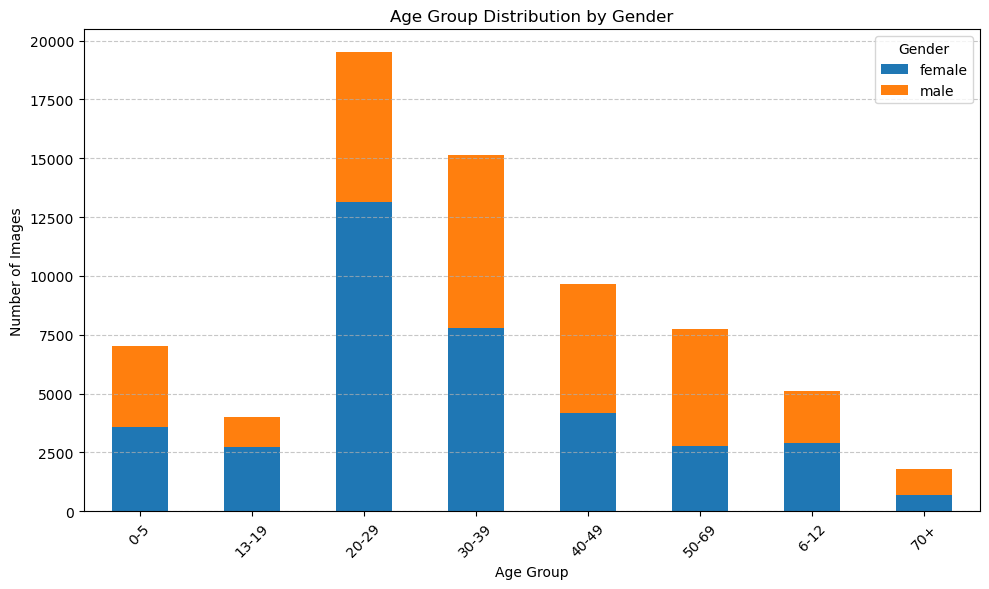

: 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the aligned dataset
df = pd.read_csv('aligned_dataset.csv')

# Group by age group and gender
grouped = df.groupby(['age_group_binned', 'gender']).size().unstack(fill_value=0)

# Plotting
ax = grouped.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Age Group Distribution by Gender')
plt.xlabel('Age Group')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()
